<a href="https://colab.research.google.com/github/Chamal-Dakshana/TMP-2023-24-90/blob/IT20102296/Blood_Cancer_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Install Dependies and Setup**

In [1]:
import tensorflow as tf
import os

In [2]:
pip install np_utils

In [3]:
pip install --upgrade keras

In [43]:
import time
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
np.random.seed(2017)

#Keras, deep learning libraries
from keras.models import Sequential, load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Convolution2D, MaxPooling2D
from keras.layers import Activation, Flatten, Dense, Dropout, Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from keras.utils import to_categorical
from keras import backend as K
from keras.datasets import cifar10
import os
import tensorflow as tf
from tensorflow.python.client import device_lib

import pickle
import pandas as pd
from skimage import io
from scipy import misc
import skimage.transform as st
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import h5py
from flask import Flask, request, render_template
from keras.preprocessing.image import ImageDataGenerator
import cv2
import imghdr

Populating the interactive namespace from numpy and matplotlib


1.1 Add the Data set

In [5]:
! pip install -q kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download 'mohammadamireshraghi/blood-cell-cancer-all-4class'

mkdir: cannot create directory ‘/root/.kaggle’: File exists
blood-cell-cancer-all-4class.zip: Skipping, found more recently modified local copy (use --force to force download)


In [6]:
! unzip blood-cell-cancer-all-4class

1.2 Remove dodgy

In [8]:
data_dir = 'Blood cell Cancer [ALL]'

In [9]:
os.listdir(data_dir)

['[Malignant] Pre-B', 'Benign', '[Malignant] Pro-B', '[Malignant] early Pre-B']

In [10]:
image_exts = ['jpeg','jpg','bmp','png']

In [11]:
for image_class in os.listdir(data_dir):
  for image in os.listdir(os.path.join(data_dir, image_class)):
      image_path = os.path.join(data_dir, image_class, image)
      try:
          img = cv2.imread(image_path)
          tip = imghdr.what(image_path)
          if tip not in image_exts:
              print('image not in ext list {}'.format(image_path))
              os.remove(image_path)
      except Exception as e:
          print('Issue with image {}'.format(image_path))

1.3 Load Data

In [12]:
tf.data.Dataset

tensorflow.python.data.ops.dataset_ops.DatasetV2

In [13]:
data = tf.keras.utils.image_dataset_from_directory(data_dir, image_size=(224, 224), batch_size=32)

Found 3242 files belonging to 4 classes.


In [14]:
data_iterator = data.as_numpy_iterator()

In [15]:
class_names = os.listdir(data_dir)

In [16]:
batch = data_iterator.next()

In [17]:
batch[0].shape

(32, 224, 224, 3)

In [18]:
class_names

['[Malignant] Pre-B', 'Benign', '[Malignant] Pro-B', '[Malignant] early Pre-B']

In [19]:
class_names[1]

'Benign'

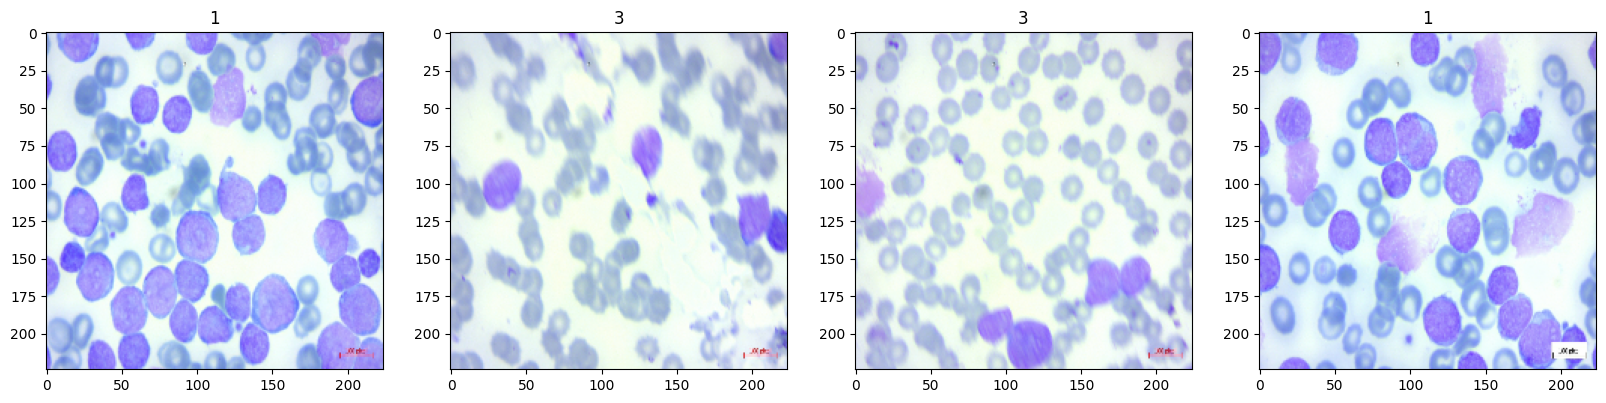

In [20]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

2 Preprocess Data

2.1 Scale Data

In [44]:
data =data.map(lambda x, y: (x/255, y))

In [45]:
scaled_iterator = data.as_numpy_iterator()

In [46]:
batch = scaled_iterator.next()

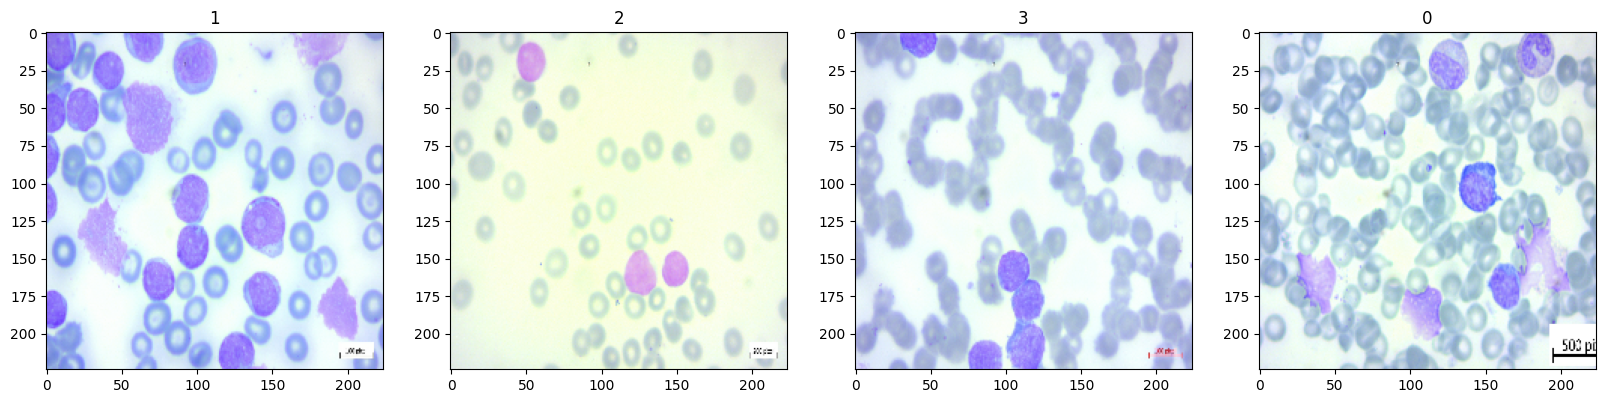

In [47]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

2.2 Split Data

In [21]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [22]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

**3.Deep Model**

In [23]:
!pip install efficientnet

3.1 Build Deep Learning Model & Train

In [24]:
import tensorflow as tf
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers.experimental.preprocessing import Rescaling, Resizing
import efficientnet.tfkeras as efn

# Define the input shape for EfficientNetB0
input_shape = (224, 224, 3)  # Adjust the input shape to match the input size of EfficientNetB0

# Create a Sequential model
model = Sequential()

# Use EfficientNetB0 with pretrained weights from ImageNet
effnet_model = efn.EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)

# Add EfficientNetB0 layers to your model
model.add(Rescaling(scale=1./255, input_shape=input_shape))  # Rescale pixel values
model.add(effnet_model)

# Flatten the output of the EfficientNet model
model.add(Flatten())

# Add custom dense layers for multi-class classification
model.add(Dense(256, activation='relu'))
model.add(Dense(4, activation='softmax'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Data preprocessing
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
])

# Apply data augmentation to the training dataset
train = train.map(lambda x, y: (data_augmentation(x, training=True), y))

# Train the model
batch_size = 16
epochs = 10

model.summary()

# Train the model
history = model.fit(train, validation_data=val, batch_size=batch_size, epochs=epochs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 efficientnet-b0 (Functiona  (None, 7, 7, 1280)        4049564   
 l)                                                              
                                                                 
 flatten (Flatten)           (None, 62720)             0         
                                                                 
 dense (Dense)               (None, 256)               16056576  
                                                                 
 dense_1 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 20107168 (76.70 MB)
Trainable params: 20065152 (76.54 MB)
Non-trainable params: 42016 (164.12 KB)
__________

3.2 Plot Performance

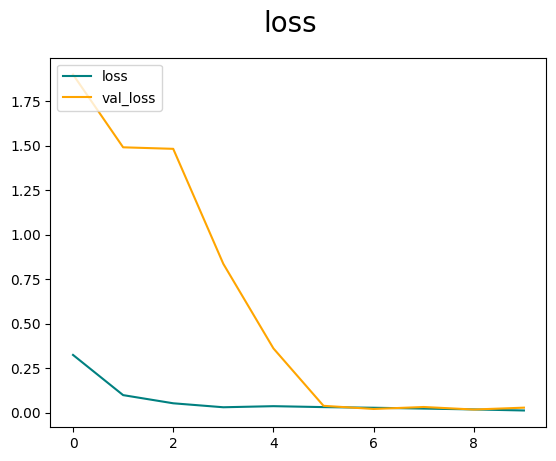

In [27]:
fig = plt.figure()
plt.plot(history.history['loss'], color='teal', label='loss')
plt.plot(history.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

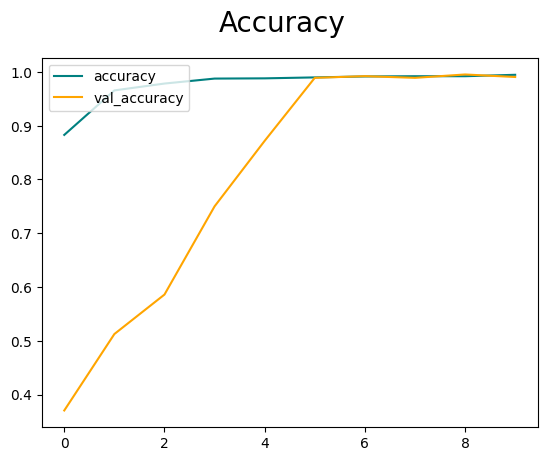

In [28]:
fig = plt.figure()
plt.plot(history.history['accuracy'], color='teal', label='accuracy')
plt.plot(history.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [29]:
class_names

['[Malignant] Pre-B', 'Benign', '[Malignant] Pro-B', '[Malignant] early Pre-B']

**4 Evaluate Performance**

4.1 Test

In [41]:
def predict_image_category(image_path):
    img = tf.keras.utils.load_img(image_path, target_size=(224, 224))
    img_array = tf.keras.utils.img_to_array(img)
    img_array = img_array / 255.0  # Normalize the image

    # Reshape and expand dimensions to match the model's input shape
    img_array = tf.expand_dims(img_array, 0)

    # Get the model's prediction for the image
    predictions = model.predict(img_array)
    predicted_class = tf.argmax(predictions, axis=1)[0].numpy()

    # Print the predicted class and label
    print(f'Predicted Class: {predicted_class}')
    print(f'Predicted Label: {class_names [predicted_class]}')

In [42]:
# Path to the image you want to classify
image_path = '/content/Blood cell Cancer [ALL]/[Malignant] Pre-B/Snap_001.jpg'

# Use the function to predict the category of the image
predict_image_category(image_path)

1/1 [==============================] - 0s 29ms/step
Predicted Class: 1
Predicted Label: Benign
